# PS5: The Apples Versus Oranges Problem as a Markov Decision Process
Problem set 5 (PS5) tests the hypothesis that a classical optimization problem, such as selecting the optimal consumption bundle of apples and oranges, can be structured as a Markov Decision Process (MDP), where an optimal policy can be computed using value iteration. Toward this objective, there are two problems that we need to solve:

* __Problem 1__: In this problem, we solve the apples and oranges problem subject to a budget constraint as a nonlinear programming problem [using the `MadNLP.jl` package](https://github.com/MadNLP/MadNLP.jl). The optimal solution to this problem will be used as the terminal state for the MDP calculations.
* __Problem 2__: In this problem, we construct an MDP problem encoding the apples and oranges decision and solve for the optimal policy function $\pi$ using value iteration. In this problem, we enforce the budget constraint as a soft-wall constraint and use reward shaping to help the search.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include("Include-student.jl");

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Helper Function: Cobb-Douglas Utility

We need a utility function to evaluate the desirability of different combinations of apples and oranges. The utility function `U(...)` computes the utility of combinations of apples and oranges using a Cobb-Douglas utility model. A tuple holding the number of `(apples, oranges)`, i.e., the combinations of objects we are searching over, and the $\alpha$-vector (preferences) are passed as arguments; the `utility` value is returned.

In [2]:
function U(x::Tuple{Int,Int}, α::Array{Float64,1})::Float64
    
    # get the apples, and oranges 
    apples = x[1];
    oranges = x[2];
    
    # compute the objective -
    utility = (apples^α[1])*(oranges^α[2]);
    
    # return -
    return utility;
end;

___

## Problem 1: Compute the optimal number of Apples and Oranges to purchase
In this problem, we compute the optimal number of apples and oranges to purchase given a budget constraint using nonlinear programming, i.e., we maximize the utility function subject to the budget constraint.

### Problem Statement
Use a Cobb-Douglas utility function combined with a budget constraint to compute the optimal combination of apples and oranges that gives the maximum utility for the available budget. The Cobb-Douglas utility function for a collection of objects $x_{1},\cdots,x_{n}$ is given by:
$$
\begin{align*}
\text{maximize } U(x_{1},\cdots,x_{n}) &= \prod_{i=1}^{n}x_{i}^{\alpha_{i}}\\
\text{subject to } \sum_{i=1}^{n}p_{i}x_{i} &\leq B\\
x_{i} &\geq 0, \quad i=1,\cdots,n
\end{align*}
$$
where the $\alpha_{i}\geq{0}$ parameters are preference coefficients associated with each object, $p_{i}$ is the unit price of object $i$, $x_{i}$ are the quantities of each object, and $B$ is the total budget available for purchasing the objects.

> __Setup__:
>
> For this problem, let's assume we have the following parameters:
> * The preference coefficient vector $\alpha = (0.55,0.45)$ and the total budget $B$ = `50 USD`
> * The unit price of an `apple` is `0.98 USD` and the unit price of an `orange` is `1.49 USD`
> * Let `apples` be index `1` and `oranges` be index `2`
> * Assume the bounds run from `0` to $B/p_i$ for each good $i$ and the initial guess is `0.1*ones(2)`.

We'll use [the `build(...)` method](src/Factory.jl) to construct an instance of [the `MySimpleCobbDouglasChoiceProblem` type](src/Types.jl) holding the parameters in the `base` variable. We'll then pass `base` to [the `mysolve(...)` function](src/Compute.jl) and set the return to the variable `base_solution`.

In [3]:
base_solution, α, c, B = let 

    # initialize -
    α = [0.55, 0.45]; # coefficients
    c = [0.98, 1.49]; # price of x1 and x2
    total_budget = 50.0; # how much money we have to spend
    base_solution = nothing;

    # build my problem object -
    model = nothing;
    base = build(MySimpleCobbDouglasChoiceProblem, (
        initial = 0.1*ones(2), # initial guess
        α = α, # coefficients
        c = c, # price --> apple is 0.98USD and orange is 1.49 USD
        I = total_budget, # budget
    
        # how much of x₁ and x₂ can be we buy?
        bounds = [
            0.0 total_budget/c[1]; # Lower and Upper bound for apples
            0.0 total_budget/c[2]; # Lower and Upper bound for oranges
        ]
    ));

    # constructor
    #MySimpleCobbDouglasChoiceProblem() = new();
    #throw(ErrorException("Ooooops! You need to build the MySimpleCobbDouglasChoiceProblem model here!"));

    # TODO: call the solve function. This will return a dictionary with data about the solution
    base_solution = mysolve(base);
    #throw(ErrorException("Ooooops! You need to call the mysolve(...) function here!"));
    
    # return -
    base_solution, α, c, total_budget;
end;


This is MadNLP version v0.8.12, running with umfpack

Number of nonzeros in constraint Jacobian............:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du inf_compl lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 0.00e+00 4.71e-01 5.09e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1 -2.4856725e-01 2.22e-16 3.45e-01 1.78e+01  -1.0 3.64e-

In [4]:
base_solution

Dict{String, Any} with 3 entries:
  "argmax"          => [28.0612, 15.1007]
  "budget"          => 50.0
  "objective_value" => 21.2328

What is the optimal combination of apples and oranges?

In [5]:
optimal_apples = base_solution["argmax"][1] |> x-> round(x,digits=0) |> Int
optimal_oranges = base_solution["argmax"][2] |> x-> round(x,digits=0) |> Int
println("Optimal: (apples, oranges) = ($(optimal_apples),$(optimal_oranges))")

Optimal: (apples, oranges) = (28,15)


___

## Problem 2: Solve the Apples and Oranges problem as an MDP
Now, we solve the apples versus oranges problem as a Markov Decision Process (MDP). 

> __What are we going to do?__ 
>
> Here are the subtasks associated with solving the apples versus oranges problem as an MDP:
> * __Task 1__: Set up a $30\times{30}$ grid, encoded as an instance of the `MyRectangularGridWorldModel` type.
>   * `TODO`: Add a terminal state at the optimal combination of apples and oranges computed from Problem 1. Set the reward for this state as the optimal _integer_ fitness value calculated using the `U(...)` function defined above.
>   * `TODO`: Add the optimal combination of apples and oranges computed from Problem 1 to the `absorbing_state_set`.
> * __Task 2__: Use your `MyRectangularGridWorldModel` instance to generate the components of the MDP, namely, the reward function (or array) $R(s, a)$ and the model of the physics of the world in the transition function (or array) $T(s, s^{\prime}, a)$.
>    * `TODO`: Modify the $R[s,a]$ array code from lecture `L11d` so that it uses the `U(...)` function for its values. This is a type of reward shaping, as we use the utility function model to give the agent some hints along the way.
>    * `TODO`: Modify the $R[s,a]$ array to describe a _soft wall_, i.e., a region where the budget constraint is violated. Unlike a hard wall that makes states unreachable, a soft wall assigns a penalty but still allows the agent to explore these states. Set the wall penalty as `-1000` and allow up to a `1 USD` violation of the budget constraint before applying the penalty.
> * __Task 3__: Use value iteration to estimate the optimal value function $U^{\star}(s)$. 
>    * `TODO`: For your choice of the $(\gamma,k_{\max},\epsilon)$ hyperparameters, extract the action-value function $Q(s, a)$ from the optimal value function $U^{\star}(s)$ and compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$.

Let's implement these tasks step by step.

### Task 1: Build the Apples and Oranges world model
In this task, we build the apples and oranges world model as a rectangular grid world. We encode the rectangular grid world as an instance of the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. 

First, let's set up the data for the apples and oranges world, i.e., set up the states, actions, and rewards, and then construct the world model. 
* `TODO`: Set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` available to the agent, and the discount factor $\gamma$.
* `TODO`: Compute the number of states and set up the state set $\mathcal{S}$ and the action set $\mathcal{A}$.

Update any missing values:

In [6]:
number_of_rows =50 # TODO: set the number of rows in the grid
number_of_cols = 50 # TODO: set the number of columns in the grid
nactions = 4; # TODO: set the number of actions available to the agent (up, down, left, right)
nstates = 2500; # TODO: set this value: this is the dimension of the state space
𝒮 = range(1,stop=nstates,step=1) |> collect; # we number the states from 1 to nstates
𝒜 = range(1,stop=nactions,step=1) |> collect; # we number the actions from 1 to nactions
γ = 0.5; # set the discount factor, change to 0.5

Next, set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. 
  * `TODO`: Add a terminal state at the optimal combination of apples and oranges computed from Problem 1. Set the reward for this state to be the optimal _integer_ fitness value (reported above), using the `U(...)` function.
  * `TODO`: Add the optimal combination of apples and oranges computed from Problem 1 to the `absorbing_state_set::Set{Tuple{Int,Int}}.` If we arrive at an absorbing state, we stay there.

In [8]:
my_objective_value = U((optimal_apples, optimal_oranges), α)
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(optimal_apples, optimal_oranges)] = my_objective_value;

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (optimal_apples, optimal_oranges));

Finally, build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. 

Pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into [the `build(...)` method](src/Factory.jl). Save the world model instance to the `world::MyRectangularGridWorldModel` variable.

In [9]:
world = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

In [10]:
println("Grid world created with $(world.number_of_rows)×$(world.number_of_cols) = $nstates states")
println("Terminal state set at: (apples, oranges) = ($(optimal_apples), $(optimal_oranges))")

Grid world created with 50×50 = 2500 states
Terminal state set at: (apples, oranges) = (28, 15)


___

### Task 2: Generate the components of the MDP problem
In this task, we generate the components of the MDP problem from our `MyRectangularGridWorldModel` instance. The MDP problem requires the reward function (or array) $R(s, a)$ and the transition function (or array) $T(s, s^{\prime}, a)$. Let's construct these from our grid world model instance, starting with the $R(s, a)$ reward function.

#### Rewards $R(s,a)$
We'll encode the reward function as a $\dim\mathcal{S}\times\dim\mathcal{A}$ array, which holds the __immediate__ reward values for being in state $s\in\mathcal{S}$ and taking action $a\in\mathcal{A}$. After initializing the reward `R::Array{Float64,2}` array with zeros, populate the non-zero values of $R(s, a)$ using a nested [for loop](https://docs.julialang.org/en/v1/base/base/#for). During each outer loop iteration, we select a state $s\in\mathcal{S}$, and the inner loop iterates over actions $a\in\mathcal{A}$.

For each state `s` and action `a` with corresponding move $\Delta$:
* Compute the new position resulting from implementing action `a` and store this in the `new_position` variable. If the `new_position`$\in\mathcal{S}$ is in our initial `rewards` dictionary, we use that reward value. If we are still in the world but not in a special location, we set the reward to `-1`. If `new_position`$\notin\mathcal{S}$, i.e., the `new_position` is a space outside the grid, we set a penalty of `-50000.0`.

#### Modifications
The implementation below will be similar to lab `L11d`, but with a few modifications:
* `TODO`: Modify the $R[s,a]$ array from `L11d` so that it uses the `U(...)` function for the default values. This is a type of reward shaping.
* `TODO`: Modify the $R[s, a]$ array to describe a `soft wall`, i.e., a region where the budget constraint is violated. Set the `wall` penalty as `-1000`. Allow up to a `1 USD` violation of the budget constraint. The off-the-grid penalty is set to `-50000.0`.

Go!

In [11]:
R, soft_wall_set = let

    # initialize -
    total_budget = B; # alias the total budget
    R = zeros(nstates, nactions);
    fill!(R, 0.0)
    off_grid_penalty = -50000.0; # this is the penalty for going off the grid

    for s ∈ 𝒮
        for a ∈ 𝒜
            
            Δ = world.moves[a];
            current_position = world.coordinates[s]
            new_position =  current_position .+ Δ
            
            # TODO: You need to complete the implementation of R matrix here

            if (haskey(world.states, new_position) == true)
                if (haskey(rewards, new_position) == true)
                    R[s,a] = rewards[new_position];
                else
                    R[s,a] = U(new_position, α);
                end
            else
                R[s,a] = off_grid_penalty; # we are off the grid, big negative penalty
            end
        end
    end
    

    # setup soft walls -
    soft_wall_set = Set{Tuple{Int,Int}}();
    for s ∈ 𝒮
        
        # get the position -
        current_position = world.coordinates[s]
        
        # TODO: current_position violate the budget? (with a 1 USD grace)?
        # TODO: Hint: think about this like a penalty function
        # if yes, store this position in the soft_wall_set
        budget_violation = max(0.0, c[1]*current_position[1]+c[2]*current_position[2] - total_budget)
        if (budget_violation ≥ 5.0)
            push!(soft_wall_set, current_position)
        end
    end

    for s ∈ 𝒮
        current_position = world.coordinates[s]
        for a ∈ 𝒜
            Δ = world.moves[a];
            new_position =  current_position .+ Δ
            
            if (in(new_position, soft_wall_set) == true)
                R[s,a] = -1000.0  
            end
        end
    end

    R, soft_wall_set; # return 
end;

In [12]:
println("Reward matrix R dimensions: $(size(R))")
println("Number of soft wall states: $(length(soft_wall_set))")
println("Soft wall states represent budget violations ≥ 1 USD")

Reward matrix R dimensions: (2500, 4)
Number of soft wall states: 1519
Soft wall states represent budget violations ≥ 1 USD


#### Transition $T(s, s^{\prime},a)$
Next, build the transition function $T(s,s^{\prime},a)$. We'll encode this as a $\dim\mathcal{S}\times\dim\mathcal{S}\times\dim\mathcal{A}$ [multidimensional array](https://docs.julialang.org/en/v1/manual/arrays/) and populate it using nested `for` loops. I've already done this, so back away slowly from your keyboard and move on to the next task!

But if you're curious, here's how it works:
* In the `outer` loop, we iterate over actions. For every $a\in\mathcal{A}$, we get the move associated with that action and store it in the `Δ::Tuple`.
* In the `inner` loop, we iterate over states $s\in\mathcal{S}$. We compute a `new_position` resulting from implementing action $a$ and check if `new_position`$\in\mathcal{S}$. If `new_position` is in the world and `current_position` is _not_ an `absorbing state`, we set $s^{\prime}\leftarrow$`world.states[new_position]` and `T[s, s′,  a] = 1.0`.
* However, if the `new_position` is outside of the grid (or we are jumping from an `absorbing` state), we set `T[s, s,  a] = 1.0`, i.e., the probability that we stay in `s` if we take action `a` is `1.0`.

In [13]:
T = let

    # --- DO NOT CHANGE ME .... PUT YOUR HANDS DOWN, AND SLOWLY STEP AWAY FROM YOUR KEYBOARD --------------- #
    
    # initialize -
    T = Array{Float64,3}(undef, nstates, nstates, nactions);
    fill!(T, 0.0);

    # main loop -
    for a ∈ 𝒜
        Δ = world.moves[a]; # for this action, get the coordinate move
        for s ∈ 𝒮
            current_position = world.coordinates[s]
            new_position =  current_position .+ Δ
            if (haskey(world.states, new_position) == true && 
                    in(current_position, absorbing_state_set) == false)
                s′ = world.states[new_position];
                T[s, s′,  a] = 1.0
            else
                T[s, s,  a] = 1.0
            end
        end
    end
    # ----------------------------------------------------------------------------------------------------- #

    T # return
end;

In [14]:
println("Transition matrix T dimensions: $(size(T))")
println("T encodes deterministic transitions between states")

Transition matrix T dimensions: (2500, 2500, 4)
T encodes deterministic transitions between states


___

## Task 3: Use value iteration to estimate the optimal value function $U^{\star}(s)$
In Task 3, we construct a Markov Decision Process (MDP) instance and solve the problem using value iteration. The solution of the value iteration procedure is then used to estimate the optimal policy $\pi^{\star}(s)$. Toward this task:

Construct an instance of the `MyMDPProblemModel`, which encodes the data required to solve the MDP problem. Pass the states `𝒮`, the actions `𝒜`, the transition matrix `T`, the reward matrix `R`, and the discount factor `γ` into [the `build(...)` method](src/Factory.jl). We store the MDP model in the `m::MyMDPProblemModel` variable:

In [15]:
m = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ)); # build an mdp model

In [16]:
println("MDP model constructed with:")
println("  - State space size: $(length(m.𝒮))")
println("  - Action space size: $(length(m.𝒜))")
println("  - Discount factor γ: $(m.γ)")

MDP model constructed with:
  - State space size: 2500
  - Action space size: 4
  - Discount factor γ: 0.5


Next, call [the `mysolve(...)` method](src/Compute.jl) by passing a `value_iteration_model` instance and our MDP model `m::MyMDPProblemModel` as arguments. [The `mysolve(...)` method](src/Compute.jl) iteratively computes the optimal value function $U^{\star}(s)$ and returns it in an instance of [the `MyValueIterationSolution` type](src/Types.jl).

In [17]:
solution = nothing
k_max = 2500
ϵ = 1e-8
value_iteration_model = MyValueIterationModel(k_max)

t = @elapsed begin
    solution = mysolve(value_iteration_model, m, ϵ=ϵ)
end

println("MDP solved using Value Iteration in $(t) seconds")


MDP solved using Value Iteration in 3.709040958 seconds


Now, we extract the action-value function $Q(s, a)$ from the optimal value function $U^{\star}(s)$. First, we estimate $Q(s,a)$ as:

> __Policy__: To extract the policy, we need to compute the __state-action value function__ $Q(s,a)$ for each state and action. To estimate the policy, for each state $s \in \mathcal{S}$, compute:
> $$
\begin{align*}
\pi^{*}(s) &\gets \arg\max_{a\in\mathcal{A}_s}\left(\underbrace{R(s,a) + \gamma\sum_{s^{\prime}\in\mathcal{S}}T\left(s^{\prime}\,|\,s,a\right)\cdot{U^{*}}(s^{\prime})}_{Q(s,a)\text{ = brain of agent}}\right)
\end{align*}
$$
> We can do this using [the `QM(...)` function](src/Compute.jl), which takes `m::MyMDPProblemModel` and the `solution::MyValueIterationSolution`. 

Save the optimal $Q(s,a)$ in the `my_Q::Array{Float64,2}` variable:

In [18]:
my_Q = QM(m, solution.U) # this computes the state-action value function Q(s,a)

2500×4 Matrix{Float64}:
 -49998.0       3.96544  -49998.0           3.8674
 -49997.5       5.00271       2.98272       4.59252
 -49997.0       5.9061        3.8674        5.21296
 -49996.7       6.69379       4.59252       5.75926
 -49996.3       7.39217       5.21296       6.25013
 -49996.0       8.02109       5.75926       6.6985
 -49995.7       8.59608       6.25013       7.11313
 -49995.4       9.12801       6.6985        7.50023
 -49995.2       9.62471       7.11313       7.86437
 -49995.0      10.092         7.50023       8.209
      ⋮                                
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0       -2000.0
  -2000.0  -51000.0       -2000.0   

Finally, compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$ using [the `mypolicy(...)` function](src/Compute.jl). Save this in the `my_π::Array{Int64,1}` variable:

In [19]:
my_π = mypolicy(my_Q) # this tells us what we should do at each state

2500-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [20]:
println("Optimal policy π computed for all $(length(my_π)) states")

Optimal policy π computed for all 2500 states


### Visualize the optimal policy
The code block below shows how we visualize the decision-maker's path through the apples versus oranges space to arrive at the optimal solution. This code to visualize the optimal policy $\pi^{\star}(s)$ was modified from `L11d`.

Specify an initial starting tuple `(apples, oranges)` in the `initial_site` variable:

In [21]:
initial_site = (1, 30); # horizontal, vertical

This code block generates the plot showing the optimal navigation path from the starting position to the goal while avoiding hazards:

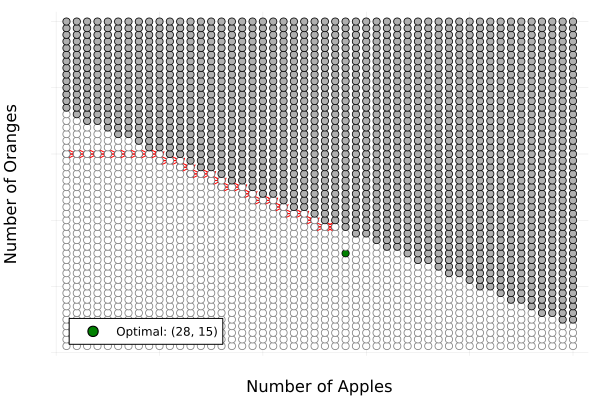

In [22]:
let
    # draw the path -
    p = plot();
    hit_absorbing_state = false
    s = world.states[initial_site];
    visited_sites = Set{Tuple{Int,Int}}();
    push!(visited_sites, initial_site);
    
    while (hit_absorbing_state == false)
        current_position = world.coordinates[s]
        a = my_π[s];
        Δ = world.moves[a];
        new_position =  current_position .+ Δ
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
        plot!([current_position[1], new_position[1]],[current_position[2], new_position[2]], label="", arrow=true, lw=1, c=:red)
        
        if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
            hit_absorbing_state = true;
        else
            s = world.states[new_position];
            push!(visited_sites, new_position);
        end
    end
    
    # draw the grid -
    for s ∈ 𝒮
        current_position = world.coordinates[s]
        a = my_π[s];
        Δ = world.moves[a];
        new_position =  current_position .+ Δ
        
        if (haskey(rewards, current_position) == true && rewards[current_position] == my_objective_value)
            scatter!([current_position[1]],[current_position[2]], label="Optimal: $(current_position)", c=:green, ms=4, legend=:bottomleft)
        elseif (in(current_position, soft_wall_set) == true)
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
        else
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:gray50, c=:white)
        end
    end
    xlabel!("Number of Apples",fontsize=18)
    ylabel!("Number of Oranges",fontsize=18)
    current()
end

#### Interpretation
The plot above shows the optimal navigation path (red arrows with blue dots) from the starting position to the optimal consumption bundle (green dot). Notice the following key features:
* The __green dot__ marks the optimal combination of apples and oranges computed in Problem 1.
* The __gray region__ represents the soft-wall states where the budget constraint is violated by ≥ 1 USD.
* The __optimal path__ (red arrows) navigates through feasible states, avoiding the budget-violating region, and terminates at the goal state.
* The policy guides the agent from any starting position toward the optimal consumption bundle while respecting the budget constraint.

___

### Exploration: Parameter Sensitivity Analysis
Now that you have a working MDP solution, explore how different parameters affect the optimal policy and convergence behavior. Answer the following questions by modifying the appropriate parameters in the notebook above and re-running the relevant cells.

#### Question 1: Effect of the Discount Factor
What happens to the optimal policy when you decrease the discount factor $\gamma$ from `0.95` to `0.50`? 

__Task__: Change $\gamma$ to `0.50`, re-run the MDP construction and value iteration cells, and observe the resulting policy. Does the agent still navigate efficiently to the optimal consumption bundle? Why or why not?

__Your Answer__: 
When the discount factor changed from 0.95 to 0.5, the agent did NOT navigate efficiently to the optimal policy because it never reached that point. From problem 1, we know the optimal solution is 28 apples and 15 oranges. When discount is at 0.95, the agent is able to nagivate to the optimal solution, but as it decreases, it cannot arrive to the optimal solution. The Discount factor, Y, is a parameter that weights future rewards relative to immediate rewards, with prioritizing immediate rewards and valuing long-term returns. The optimal value function U(s) computes the next value by weighing the max (Reward of immediate action, Y*One step ahead). This means that when Y --> 1, the agent looks at long term rewards and weighs future rewards when making its decisions. To get to the best possible solution, a Y that approaches 1 is needed. When Y --> 0, the agent looks at short term rewards, only immediate rewards. This is why decreasing the gamma to 0.5 made the agent unable to reach the optimal solution, because they weighed their decisions on immediate rewards instead of longterm reward. 

In [23]:
# Set this flag to true once you have answered Question 1
did_I_answer_question_1 = true;

#### Question 2: Soft-Wall Tolerance Impact
How does changing the soft-wall tolerance affect the size of the feasible region and the optimal policy?

__Task__: Modify the budget violation threshold from `1.0 USD` to `5.0 USD` in the soft-wall setup (where we check `if (budget_violation ≥ 1.0)`). Re-run the reward matrix construction and subsequent cells. How does the size of `soft_wall_set` change? Does the optimal path change significantly?

__Your Answer__: _(Write your observations and explanation here)_
The number of soft-wall states when the budget violation threshold increased from 1 USD to 5 USD decreased from 202 to 140. The size of the soft wall set decreased because fewer states are classified as budget-violating and receive the −1000 penalty. 
This change means the agent has more non-penalized routes available, so in principle it should be easier to reach the terminal optimal bundle. The agent, however, failed to reach the optimal solution after this change, most likely because the current position could violate the budget (with a $5 USD grace, instead of $1 USD grace) such that more less positions violate this constraint and are stored in the soft wall set. Thus, the size of the soft-wall tolerance decreases as the tolerance increases and this results in the budget being used up before the optimal solution is reached. 

In [24]:
# Set this flag to true once you have answered Question 2
did_I_answer_question_2 = true;

#### Question 3: Grid Resolution and Computational Cost
What is the trade-off between grid resolution and computational performance?

__Task__: Change the grid size from $30\times 30$ to $50\times 50$ by modifying `number_of_rows` and `number_of_cols`. Re-run all relevant cells from Task 1 onward. Compare the computation time for value iteration and observe whether the optimal consumption bundle changes (it should remain approximately the same since Problem 1 is independent of the grid). What is the computational cost of increasing the state space?

__Hint__: You can measure execution time in Julia using the `@elapsed` macro, e.g., `time_taken = @elapsed mysolve(value_iteration_model, m)`.

__Your Answer__: As the grid size increased from 20x30 to 50x50, the number of possible states increases. This made the soft wall tolerance area 1653 states (much larger than 202 states with a 30x30 grid).The time is took for the MDP to solve using Value Iteration is 2.133842958 seconds for a 30x30 grid. For a larger state space of 50x50 grid, MDP solved using Value Iteration in 43.461202875 seconds. This shows that increasing the grid size by a factor of 2.7 (900 to 2500 states) resulted in a time increase of 20.4. The trade off between computational performance is that a smaller grid size will get the agent to the optimal solution and a larger grid takes lots of time to compute and is not efficient. Although a larger grid resolution is able to get to the correct answer, computational time increases and makes finding the solution innefficient. A smaller grid size is also capable of getting to the best solution with a high discount factor and low soft wall tolerance.


In [28]:
# Set this flag to true once you have answered Question 3
did_I_answer_question_3 = true;

___

## Summary
We demonstrated that the apples and oranges resource allocation problem can be formulated and solved as a Markov Decision Process using value iteration.

> Key takeaways:
> * The optimal consumption bundle from nonlinear programming (Problem 1) served as the terminal state for the MDP, providing a clear goal for the value iteration algorithm to converge toward.
> * Reward shaping with the Cobb-Douglas utility function $U(x)$ guided the MDP search by providing intermediate feedback, while soft-wall penalties enforced the budget constraint without hard boundaries.
> * Value iteration successfully computed an optimal policy $\pi^{\star}(s)$ that navigates from any starting state to the optimal consumption bundle while respecting the budget constraint.

This approach shows how classical optimization problems can be reframed as sequential decision-making problems, opening pathways to solve more complex resource allocation scenarios with uncertainty and dynamic constraints.
___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [26]:
@testset verbose = true "CHEME 5800 PS5 Test Suite" begin

    @testset "Problem 1: Optimal Apples and Oranges (NLP)" begin
        
        # Test that base_solution exists and has the correct structure
        @test @isdefined(base_solution)
        @test isa(base_solution, Dict)
        @test haskey(base_solution, "argmax")
        @test haskey(base_solution, "objective_value")
        
        # Test that optimal values are defined and are integers
        @test @isdefined(optimal_apples)
        @test @isdefined(optimal_oranges)
        @test isa(optimal_apples, Int)
        @test isa(optimal_oranges, Int)
        
        # Test that optimal values are non-negative
        @test optimal_apples ≥ 0
        @test optimal_oranges ≥ 0
        
        # Test that the solution respects reasonable bounds (not exact due to parameter flexibility)
        @test optimal_apples < 100  # reasonable upper bound
        @test optimal_oranges < 100 # reasonable upper bound
        
        # Test that α, c, and B are defined with correct dimensions
        @test @isdefined(α)
        @test @isdefined(c)
        @test @isdefined(B)
        @test length(α) == 2
        @test length(c) == 2
        @test B > 0
    end

    @testset "Task 1: Grid World Model Setup" begin
        
        # Test that grid dimensions are defined
        @test @isdefined(number_of_rows)
        @test @isdefined(number_of_cols)
        @test number_of_rows > 0
        @test number_of_cols > 0
        
        # Test that state and action spaces are defined correctly
        @test @isdefined(nstates)
        @test @isdefined(nactions)
        @test @isdefined(𝒮)
        @test @isdefined(𝒜)
        @test nstates == number_of_rows * number_of_cols
        @test length(𝒮) == nstates
        @test length(𝒜) == nactions
        @test nactions == 4  # 4 cardinal directions
        
        # Test that discount factor is defined and in valid range
        @test @isdefined(γ)
        @test 0 < γ ≤ 1
        
        # Test that rewards dictionary is defined and contains the optimal state
        @test @isdefined(rewards)
        @test isa(rewards, Dict)
        @test haskey(rewards, (optimal_apples, optimal_oranges))
        
        # Test that absorbing state set is defined and contains the optimal state
        @test @isdefined(absorbing_state_set)
        @test isa(absorbing_state_set, Set)
        @test in((optimal_apples, optimal_oranges), absorbing_state_set)
        
        # Test that world model is constructed correctly
        @test @isdefined(world)
        @test isa(world, MyRectangularGridWorldModel)
        @test world.number_of_rows == number_of_rows
        @test world.number_of_cols == number_of_cols
        @test !isempty(world.coordinates)
        @test !isempty(world.states)
        @test !isempty(world.moves)
    end

    @testset "Task 2: MDP Components (R and T matrices)" begin
        
        # Test that R matrix is defined with correct dimensions
        @test @isdefined(R)
        @test isa(R, Array{Float64,2})
        @test size(R) == (nstates, nactions)
        
        # Test that soft wall set is defined
        @test @isdefined(soft_wall_set)
        @test isa(soft_wall_set, Set)
        
        # Test that T matrix is defined with correct dimensions
        @test @isdefined(T)
        @test isa(T, Array{Float64,3})
        @test size(T) == (nstates, nstates, nactions)
        
        # Test that T is a valid probability distribution (rows sum to 1 for each action)
        for a in 𝒜
            for s in 𝒮
                @test sum(T[s, :, a]) ≈ 1.0 atol=1e-10
            end
        end
        
        # Test that all T values are non-negative
        @test all(T .≥ 0)
        
        # Test that MDP model is constructed
        @test @isdefined(m)
        @test isa(m, MyMDPProblemModel)
        @test m.𝒮 == 𝒮
        @test m.𝒜 == 𝒜
        @test m.γ == γ
    end

    @testset "Task 3: Value Iteration and Policy Extraction" begin
        
        # Test that solution is defined and has correct structure
        @test @isdefined(solution)
        @test hasfield(typeof(solution), :U)
        
        # Test that value function U has correct dimensions
        @test length(solution.U) == nstates
        
        # Test that Q matrix is defined with correct dimensions
        @test @isdefined(my_Q)
        @test isa(my_Q, Array{Float64,2})
        @test size(my_Q) == (nstates, nactions)
        
        # Test that policy is defined with correct dimensions
        @test @isdefined(my_π)
        @test isa(my_π, Array{Int64,1})
        @test length(my_π) == nstates
        
        # Test that all policy actions are valid (in action space)
        @test all(a -> a ∈ 𝒜, my_π)
        
        # Test that initial site is defined
        @test @isdefined(initial_site)
        @test isa(initial_site, Tuple{Int,Int})
        @test initial_site[1] > 0 && initial_site[1] ≤ number_of_cols
        @test initial_site[2] > 0 && initial_site[2] ≤ number_of_rows
    end

    @testset "Helper Functions" begin
        
        # Test the U function exists and works correctly
        @test @isdefined(U)
        
        # Test U function with simple inputs
        test_result = U((1, 1), [0.5, 0.5])
        @test isa(test_result, Float64)
        @test test_result ≥ 0
        
        # Test U function with the optimal solution
        optimal_utility = U((optimal_apples, optimal_oranges), α)
        @test isa(optimal_utility, Float64)
        @test optimal_utility > 0
    end

    @testset "Questions" begin
        @test did_I_answer_question_1 == true
        @test did_I_answer_question_2 == true
        @test did_I_answer_question_3 == true
    end
    
end;

Test Summary:                                   |  Pass  Total  Time
CHEME 5800 PS5 Test Suite                       | 10081  10081  0.6s
  Problem 1: Optimal Apples and Oranges (NLP)   |    18     18  0.3s
  Task 1: Grid World Model Setup                |    27     27  0.0s
  Task 2: MDP Components (R and T matrices)     | 10014  10014  0.3s
  Task 3: Value Iteration and Policy Extraction |    14     14  0.0s
  Helper Functions                              |     5      5  0.0s
  Questions                                     |     3      3  0.0s
